In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
dataset = pd.read_csv('final_dataset')
dataset['date'] = pd.to_datetime(dataset['date'])
dataset = dataset.sort_values(by = 'date')

In [3]:
dataset.set_index('date', inplace = True)

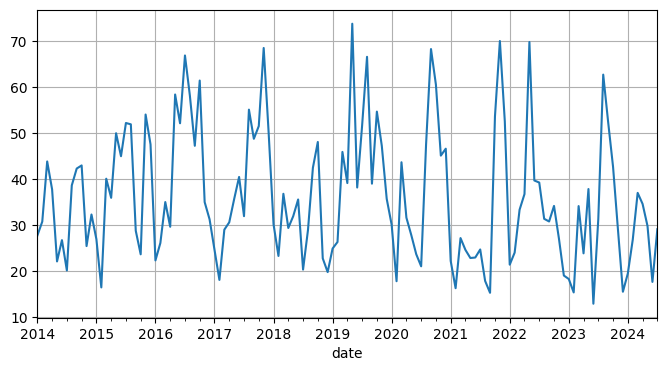

In [4]:
period = slice("2014", "2024")
df_monthly = dataset.resample('ME').mean(numeric_only=True)
df_monthly['tomato_small_local'] = df_monthly['tomato_small_local'].interpolate()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize = (8,4))
df_monthly['tomato_small_local'].plot(ax = ax, grid= True, legend = False)
plt.show()

In [5]:
df = df_monthly[['tomato_small_local']]
tomato_data_daily = dataset[['tomato_small_local']]

In [51]:
#dividing the data into training period

data_train  = tomato_data_daily.loc['2014-01': '2021-12']
data_valid  = tomato_data_daily.loc['2022-01': '2023-07']
data_test  = tomato_data_daily.loc['2023-08':]

data_train = data_train.ffill()
data_valid = data_valid.ffill()
data_test = data_test.ffill()

In [52]:
data_test

,tomato_small_local
date,
2023-08-01,50.00
2023-08-02,56.67
2023-08-03,56.67
2023-08-04,75.00
2023-08-05,86.67
...,...
2024-07-27,22.50
2024-07-28,22.33
2024-07-29,25.00


In [25]:
import tensorflow as tf

In [125]:
seq_length = 21
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data_train.to_numpy(),
    targets = data_train[seq_length:],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed = 42    
)


valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    data_valid.to_numpy(),
    targets = data_valid[seq_length:],
    sequence_length = seq_length,
    batch_size = 32
)

In [126]:
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data_test.to_numpy(),
    targets = data_test[seq_length:],
    sequence_length=seq_length,
    seed = 42
)

In [134]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape = [None, 1]),
tf.keras.layers.LSTM(128, return_sequences = False),
tf.keras.layers.Dense(1)
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
    callbacks=[early_stopping_cb])

Epoch 1/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 17.4423 - mae: 17.9357 - val_loss: 4.8758 - val_mae: 5.3518
Epoch 2/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3502 - mae: 6.8307 - val_loss: 5.4236 - val_mae: 5.9003
Epoch 3/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6460 - mae: 7.1266 - val_loss: 6.4438 - val_mae: 6.9287
Epoch 4/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0820 - mae: 7.5646 - val_loss: 5.0313 - val_mae: 5.5140
Epoch 5/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0728 - mae: 7.5503 - val_loss: 5.8304 - val_mae: 6.3221
Epoch 6/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7085 - mae: 8.1934 - val_loss: 5.9844 - val_mae: 6.4687
Epoch 7/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5774 - mae: 8.0587 - val_loss: 6.3620 - val_mae: 6.8540
Epoch 8/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8512 - mae: 8.3348 - val_loss: 9.0482 - val_mae: 9.5440
Epoch 9/500
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.

In [135]:
val_loss, val_mae = model.evaluate(valid_ds)
print(f"Validation MAE: {val_mae}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3662 - mae: 5.8410
Validation MAE: 5.351754665374756


In [136]:
print(data_train.isna().sum())
print(data_valid.isna().sum())
print(data_test.isna().sum())


tomato_small_local    0
dtype: int64
tomato_small_local    0
dtype: int64
tomato_small_local    0
dtype: int64


In [137]:
test_loss, test_mae = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6606 - mae: 5.1318 
Test Loss: 4.425205707550049
Test MAE: 4.892668724060059


In [150]:
predictions = model.predict(test_ds).flatten()
# predictions = np.pad(predictions, (15, 0), 'constant', constant_values=0)
padding = np.zeros(21)
predictions = np.concatenate((padding, predictions))
predictions.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


(366,)

In [151]:
actual_values = tomato_data_daily.loc['2023-08':].to_numpy()

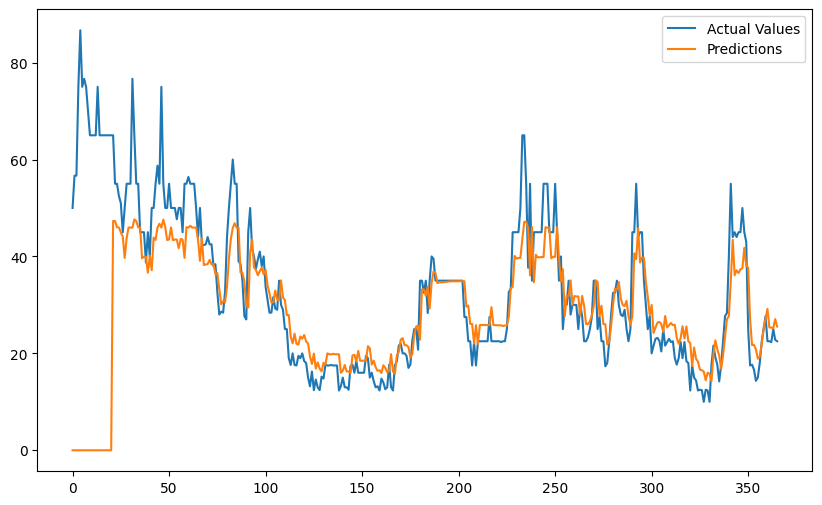

In [152]:
import matplotlib.pyplot as plt

# Assuming you have the actual values for the test set in `actual_values`
# predictions will be the output of model.predict()

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()


In [65]:
tomato_data_daily

,tomato_small_local
date,
2014-01-01,33.00
2014-01-02,33.00
2014-01-03,33.00
2014-01-04,33.00
2014-01-05,33.00
...,...
2024-07-27,22.50
2024-07-28,22.33
2024-07-29,25.00


In [62]:
actual_values.shape

(3, 1)